In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from utils.data_utils import get_datasets
from configs import load_configs
from log_tools import logger, save_results
from models import OpenSetModel, train_autoencoder
import seaborn as sns
from sklearn.metrics import roc_auc_score, balanced_accuracy_score
from eval import *

In [28]:
import torch

class DummyAutoencoder(torch.nn.Module):
    def __init__(self):
        super(DummyAutoencoder, self).__init__()

    def forward(self, x):
        return x
    
    def embed(self, x: np.ndarray) -> np.ndarray:
        return x

In [29]:
configs = load_configs("configs/config.yaml")
datasets = get_datasets(configs["data"])
log_dir = logger.initialize_logger(configs["base_log_dir"])
configs["training_kwargs"]["alpha"] = 1.0
configs["training_kwargs"]["beta"] = 1.0

ae = train_autoencoder(
    datasets["init_known"]["train"][0],
    datasets["init_known"]["train"][1],
    datasets["init_known"]["val"][0],
    datasets["init_known"]["val"][1],
    source_name="init_known",
    log_dir=log_dir,
    training_kwargs=configs["training_kwargs"],
)



Model numel: 2624768
Autoencoder training with 4125 samples and 1375 validation samples
Epoch [1/50] - Train Loss1: 50.2638, Train Loss2: 33.7111, Train TLoss: 83.9750, Val Loss1: 54.4672, Val Loss2: 35.1348, Val TLoss: 89.6019, Accuracy: 0.7156, Detection Acc: 0.9585
Epoch [2/50] - Train Loss1: 35.9447, Train Loss2: 21.3163, Train TLoss: 57.2610, Val Loss1: 43.6505, Val Loss2: 16.3478, Val TLoss: 59.9984, Accuracy: 0.7389, Detection Acc: 0.9709
Epoch [3/50] - Train Loss1: 25.4510, Train Loss2: 16.3415, Train TLoss: 41.7925, Val Loss1: 27.0783, Val Loss2: 14.6360, Val TLoss: 41.7142, Accuracy: 0.8167, Detection Acc: 0.9724
Epoch [4/50] - Train Loss1: 21.1905, Train Loss2: 13.0153, Train TLoss: 34.2058, Val Loss1: 21.4774, Val Loss2: 12.6199, Val TLoss: 34.0973, Accuracy: 0.8655, Detection Acc: 0.9825
Epoch [5/50] - Train Loss1: 19.0908, Train Loss2: 11.2070, Train TLoss: 30.2978, Val Loss1: 19.0201, Val Loss2: 11.1508, Val TLoss: 30.1709, Accuracy: 0.8975, Detection Acc: 0.9855
Epoch [

In [65]:
configs = load_configs("configs/config.yaml")
# configs["training_kwargs"]["batch_size"] = 64
# configs["training_kwargs"]["top_k"] = 1
configs["training_kwargs"]["alpha"] = 0
configs["training_kwargs"]["beta"] = 1.0
configs["training_kwargs"]["lr"] = 4.5e-4
configs["training_kwargs"]["num_epochs"] = 8
ae_without_pres = train_autoencoder(
    datasets["init_known"]["train"][0],
    datasets["init_known"]["train"][1],
    datasets["init_known"]["val"][0],
    datasets["init_known"]["val"][1],
    source_name="init_known",
    log_dir=log_dir,
    training_kwargs=configs["training_kwargs"],
    do_early_stopping=False,
    use_scheduler=False,
)

Model numel: 2624768
Autoencoder training with 4125 samples and 1375 validation samples
Epoch [1/8] - Train Loss1: 0.0000, Train Loss2: 27.0966, Train TLoss: 27.0966, Val Loss1: 0.0000, Val Loss2: 34.6086, Val TLoss: 34.6086, Accuracy: 0.7193, Detection Acc: 0.9585
Epoch [2/8] - Train Loss1: 0.0000, Train Loss2: 11.2141, Train TLoss: 11.2141, Val Loss1: 0.0000, Val Loss2: 12.2983, Val TLoss: 12.2983, Accuracy: 0.8473, Detection Acc: 0.9811
Epoch [3/8] - Train Loss1: 0.0000, Train Loss2: 6.2883, Train TLoss: 6.2883, Val Loss1: 0.0000, Val Loss2: 7.3090, Val TLoss: 7.3090, Accuracy: 0.8851, Detection Acc: 0.9782
Epoch [4/8] - Train Loss1: 0.0000, Train Loss2: 4.3964, Train TLoss: 4.3964, Val Loss1: 0.0000, Val Loss2: 5.5993, Val TLoss: 5.5993, Accuracy: 0.8945, Detection Acc: 0.9760
Epoch [5/8] - Train Loss1: 0.0000, Train Loss2: 3.4564, Train TLoss: 3.4564, Val Loss1: 0.0000, Val Loss2: 4.7638, Val TLoss: 4.7638, Accuracy: 0.8960, Detection Acc: 0.9760
Epoch [6/8] - Train Loss1: 0.0000,

/tmp/ipykernel_1260345/1777938265.py:38: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1260345/1777938265.py:48: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_1260345/1777938265.py:58: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.scatterplot(


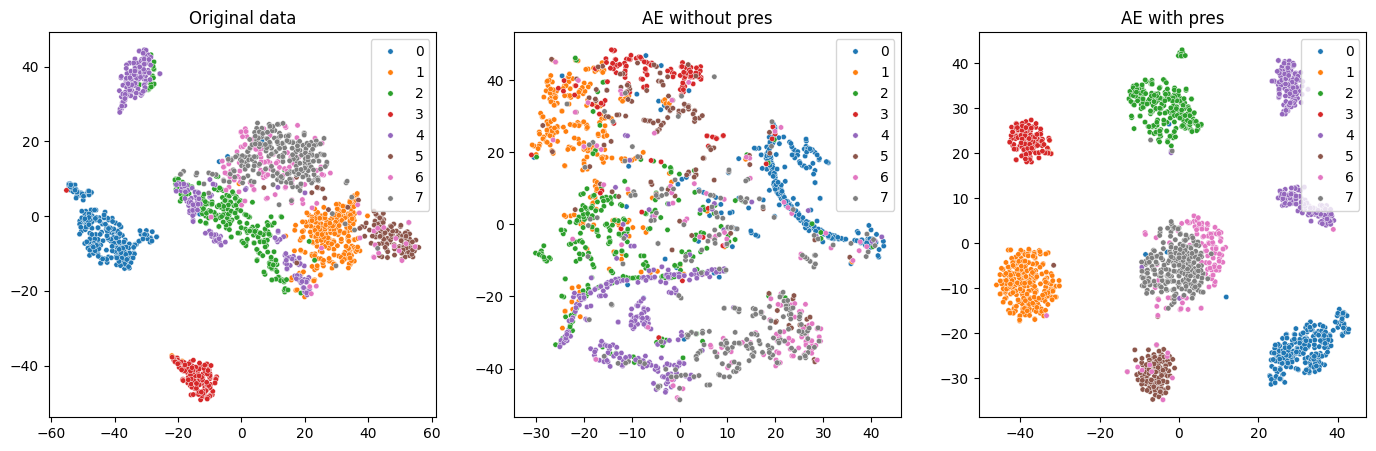

In [66]:
test_data = datasets["init_known"]["test"][0]

selected_unknowns = [7]
s = 15
cmap = "tab10"

data_unknown = datasets["emerging"]["test"][0]
labels_unknown = datasets["emerging"]["test"][1]
data_unknown_selected = []
data_unknown_selected_labels = []
for uk_id in selected_unknowns:
    data_unknown_selected.append(data_unknown[labels_unknown == uk_id])
    data_unknown_selected_labels.append(
        labels_unknown[labels_unknown == uk_id]
    )
data_unknown_selected = np.concatenate(data_unknown_selected)
data_unknown_selected_labels = np.concatenate(data_unknown_selected_labels)

test_data_combined = np.concatenate([test_data, data_unknown_selected], axis=0)
# test_data_combined = test_data
test_data_labels = np.concatenate(
    (
        datasets["init_known"]["test"][1],
        data_unknown_selected_labels,
    )
)
# test_data_labels = datasets["init_known"]["test"][1]

ae_tranformed = ae.embed(test_data_combined)
ae_without_pres_tranformed = ae_without_pres.embed(test_data_combined)

fig, ax = plt.subplots(1, 3, figsize=(17, 5))
tsne = TSNE(n_components=2)
ae_tsne = tsne.fit_transform(ae_tranformed)
ae_without_pres_tsne = tsne.fit_transform(ae_without_pres_tranformed)
test_tsne = tsne.fit_transform(test_data_combined)

sns.scatterplot(
    x=test_tsne[:, 0],
    y=test_tsne[:, 1],
    hue=test_data_labels,
    palette=sns.color_palette(cmap),
    ax=ax[0],
    s=s,
)
ax[0].set_title("Original data")

sns.scatterplot(
    x=ae_without_pres_tsne[:, 0],
    y=ae_without_pres_tsne[:, 1],
    hue=test_data_labels,
    palette=sns.color_palette(cmap),
    ax=ax[1],
    s=s,
)
ax[1].set_title("AE without pres")

sns.scatterplot(
    x=ae_tsne[:, 0],
    y=ae_tsne[:, 1],
    hue=test_data_labels,
    palette=sns.color_palette(cmap),
    ax=ax[2],
    s=s,
)
ax[2].set_title("AE with pres")

plt.show()


In [67]:
raise InterruptedError("Stop here")

InterruptedError: Stop here

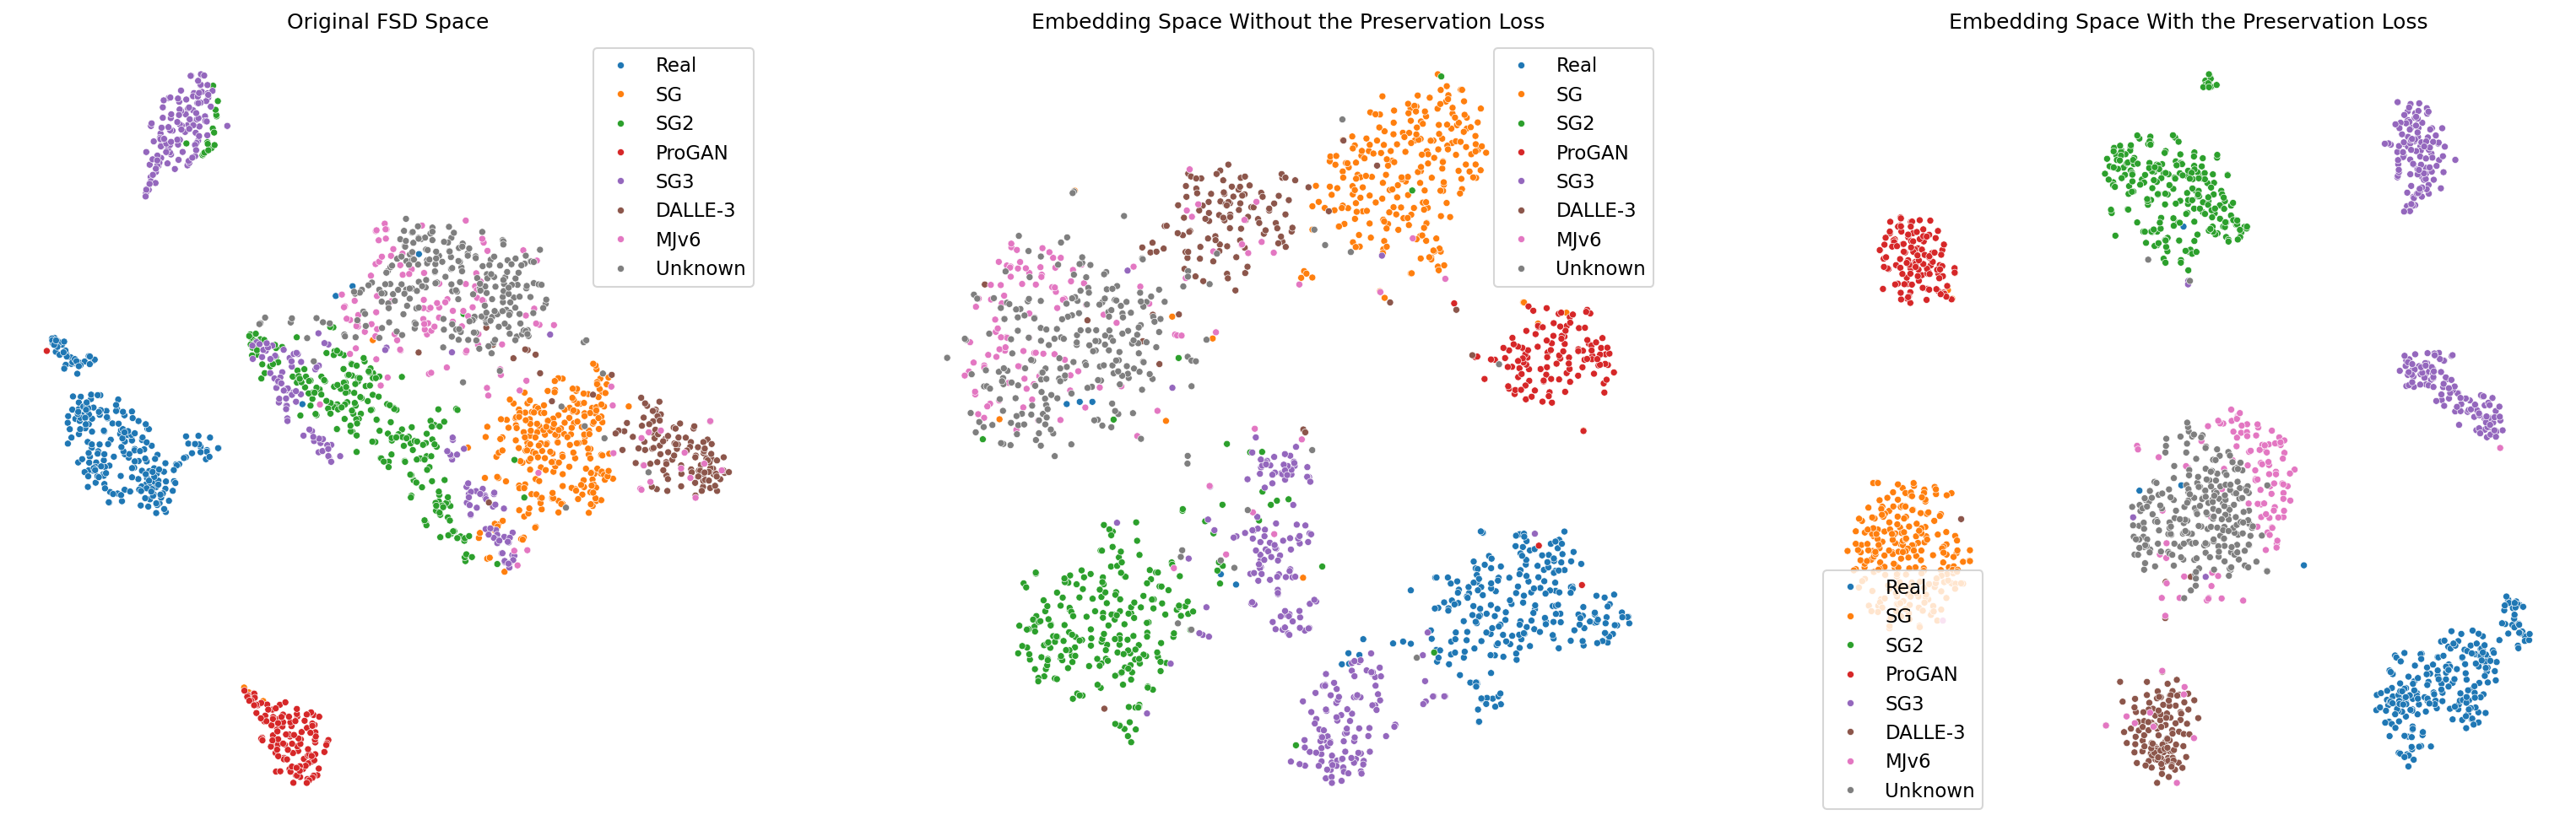

In [ ]:
# tsne = TSNE(n_components=2)
# ae_tsne = tsne.fit_transform(ae_tranformed)
# ae_without_pres_tsne = tsne.fit_transform(ae_without_pres_tranformed)
# test_tsne = tsne.fit_transform(test_data_combined)

source_names = [
    "Real",
    "SG",
    "SG2",
    "ProGAN",
    "SG3",
    "DALLE-3",
    "MJv6",
    "Unknown",
]

# Assume test_data_labels is a list or numpy array of numbers (e.g. 0, 1, 2, 3)
# Map numeric labels to the actual names:
mapped_labels = np.array(source_names)[np.array(test_data_labels)]

fig, ax = plt.subplots(1, 3, figsize=(26, 8), dpi=150)

sns.scatterplot(
    x=test_tsne[:, 0],
    y=test_tsne[:, 1],
    hue=mapped_labels,  # use string labels instead of numbers
    palette=sns.color_palette(cmap, len(source_names)),
    ax=ax[0],
    s=s,
)
ax[0].set_title("Original FSD Space")

sns.scatterplot(
    x=ae_without_pres_tsne[:, 0],
    y=ae_without_pres_tsne[:, 1],
    hue=mapped_labels,
    palette=sns.color_palette(cmap, len(source_names)),
    ax=ax[1],
    s=s,
)
ax[1].set_title("Embedding Space Without the Preservation Loss")

sns.scatterplot(
    x=ae_tsne[:, 0],
    y=ae_tsne[:, 1],
    hue=mapped_labels,
    palette=sns.color_palette(cmap, len(source_names)),
    ax=ax[2],
    s=s,
)
ax[2].set_title("Embedding Space With the Preservation Loss")

for a in ax[:1]:
    a.set_xlabel("TSNE 1", fontsize=14)
    a.set_ylabel("TSNE 2", fontsize=14)
    a.tick_params(axis='both', which='major', labelsize=12)

for a in ax:
    a.legend(fontsize=11)

# ax[0].set_title("Original FSD Space", fontsize=16)
# ax[1].set_title("Embedding Space Without the Preservation Loss", fontsize=16)
# ax[2].set_title("Embedding Space With the Preservation Loss", fontsize=16)

# remove the x and y axis labels for all plots
for a in ax:
    a.set_xlabel("")
    a.set_ylabel("")
    a.set_xticks([])
    a.set_yticks([])
    a.set_xticklabels([])
    a.set_yticklabels([])

# remove spines
for a in ax:
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.spines['left'].set_visible(False)


plt.show()


In [ ]:
# open_set_model = OpenSetModel(
#     n_components=configs["training_kwargs"]["n_components"],
#     covariance_type=configs["training_kwargs"]["cov_type"],
#     is_bayesian=configs["training_kwargs"]["is_bayesian"],
#     min_ood_tpr=configs["min_ood_tpr"],
# )

# open_set_model.fit(
#     ae.embed(datasets["init_known"]["train"][0]),
#     datasets["init_known"]["train"][1]
# )

# threshold_dataset_X = np.concatenate(
#     (
#         ae.embed(datasets["init_known"]["val"][0]),
#     )
# )
# threshold_dataset_y = np.concatenate(
#     (
#         datasets["init_known"]["val"][1],
#     )
# )
# open_set_model.find_best_thresholds(
#     threshold_dataset_X,
#     threshold_dataset_y,
# )

# test_preds = open_set_model.predict(ae.embed(test_data_combined))


In [ ]:
datasets = get_datasets(configs["data"])

In [ ]:

for selected_ae, name in zip([ae, ae_without_pres, DummyAutoencoder()], ["AE with pres", "AE without pres", "Dummy"]):
    print(f"Results for {name}")    

    ood_eval_data = np.concatenate( ( selected_ae.embed(datasets["ood"][0]), selected_ae.embed(datasets["init_known"]["test"][0]), ) )
    ood_eval_data_labels = np.concatenate( ( datasets["ood"][1], datasets["init_known"]["test"][1], ) )
    ood_binary_labels = np.concatenate( ( np.ones_like(datasets["ood"][1]), np.zeros_like(datasets["init_known"]["test"][1]), ))

    open_set_model = OpenSetModel(
        n_components=1,
        covariance_type="spherical",
        is_bayesian=False,
        min_ood_tpr=configs["min_ood_tpr"],
    )

    open_set_model.fit(
        selected_ae.embed(datasets["init_known"]["train"][0]),
        datasets["init_known"]["train"][1]
    )

    open_set_model.find_best_thresholds(
        selected_ae.embed(datasets["init_known"]["val"][0]),
        datasets["init_known"]["val"][1],
    )

    ood_decisions = open_set_model.ood_detect(ood_eval_data)
    results_ood = open_set_model.evaluate_ood(ood_decisions, ood_binary_labels)

    scores = open_set_model.predict(ood_eval_data)
    outlier_scores = np.max(scores, axis=1)  # Use max decision score for each sample
    # Flip the scores to treat higher values as more likely to be outliers
    negated_outlier_scores = -outlier_scores


    auc_crr = roc_auc_score(ood_binary_labels, negated_outlier_scores)

    src_preds = np.argmax(scores, axis=1)
    acc = balanced_accuracy_score(ood_eval_data_labels[ood_eval_data_labels <= 2], src_preds[ood_eval_data_labels <= 2])

    detection_labels = (ood_eval_data_labels == 0).astype(int)
    detection_preds = (src_preds == 0).astype(int)
    detection_acc = balanced_accuracy_score(detection_labels, detection_preds)

    oscr = compute_oscr(
        scores[ood_eval_data_labels <= 2],
        scores[ood_eval_data_labels > 2],
        ood_eval_data_labels[ood_eval_data_labels <= 2],
    )
    # oscr = compute_oscr(
    #     scores[y_test <= max_known_label],
    #     scores[y_test > max_known_label],
    #     y_test[y_test <= max_known_label],
    # )
    detection_scores1 = scores[:, 0]
    detection_scores2 = scores.max(axis=1)
    det_auc1 = roc_auc_score(detection_labels, detection_scores1)
    det_auc2 = roc_auc_score(detection_labels, detection_scores2)
    print(f"Detection Acc: {round(detection_acc, 4) * 100}")
    print(f"Det AUC1: {np.round(det_auc1, 4) * 100}")
    print(f"Det AUC2: {np.round(det_auc2, 4) * 100}")
    print(f"Src Att. Acc: {round(acc, 4) * 100}")
    print(f"AU-CRR: {np.round(auc_crr, 4) * 100}")
    print(f"OSCR: {round(oscr, 4) * 100}")
    print()
    # print(f"OSCR: {oscr}")



Results for AE with pres
Detection Acc: 98.09
Det AUC1: 99.78
Det AUC2: 64.95
Src Att. Acc: 99.63
AU-CRR: 64.19
OSCR: 64.16

Results for AE without pres
Detection Acc: 98.09
Det AUC1: 99.65
Det AUC2: 59.24
Src Att. Acc: 99.8
AU-CRR: 61.89
OSCR: 61.870000000000005

Results for Dummy
Detection Acc: 92.44
Det AUC1: 96.28
Det AUC2: 52.64
Src Att. Acc: 90.73
AU-CRR: 59.53000000000001
OSCR: 56.02



In [ ]:
detection_scores = scores[:, 0]
roc_auc_score(detection_labels, detection_scores)

0.9627752500000001

In [ ]:
(ood_decisions == ood_binary_labels).mean()

0.44988235294117646